Time to load the libraries and our dataset.

In [ ]:
from __future__ import print_function, division
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam #
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import transform
from tensorflow.keras.layers import ReLU
import imageio


import datetime
import sys
import os
from imageio import imread
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq '/content/drive/MyDrive/1a_.zip'
!unzip -qq '/content/drive/MyDrive/1b_.zip'

Mounted at /content/drive


In [ ]:
path1=sorted(glob('/content/1a' + '/*.bmp'), key=lambda name: int(name[16:-4]))
path2=sorted(glob('/content/1b' + '/*.bmp'), key=lambda name: int(name[16:-4]))


In [ ]:
def load_data(path1,path2,batch_size=1, is_val=False):


        
        #path2=np.array(path2)[inds]  
        #print(indices)
        indices=np.random.permutation(len(path1))
        b1 = np.array(path1)[indices[:batch_size]]
        b2 = np.array(path2)[indices[:batch_size]]
        #print(path1)
        #print(path2)
        #plt.imshow(b1[0])
        #plt.imshow(b2[0])
        img_res=(256,256)
        imgs_A = []
        imgs_B = []

        for i in range(0,len(b1)):
            i1=b1[i]
            i2=b2[i]
            img1 = imread(i1)
            img2=imread(i2)
            
            img_A, img_B = img1,img2

            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)
            if len(img_A.shape)==2:
                a=img_A
                    
                img_A = np.stack((a,)*3, axis=-1)
                
                
            #print(img_A)
            #print(imgs_A)
            imgs_A.append(img_A)
            imgs_B.append(img_B)
            print(img_B.shape)
            
            #print(imgs_A)

        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

This function does the same work as the above, except for the fact that is used during training to load image in batches.

In [ ]:
def load_batch( path1,path2,batch_size=1, is_val=False):

        #path2=np.array(path2)[inds]            
        #print(path1)
        #print(path2)            
        p=np.random.permutation(len(path1))
        #print(len(path1),len(path2))
        path1=np.array(path1)[p]
        path2=np.array(path2)[p]   
        #print(len(path1))
        #n_batches=batch_size
        n_batches=int(len(path1)/batch_size)-1
        
        img_res=(256,256)
        for i in range(n_batches-1):
            batch1 = path1[i*batch_size:(i+1)*batch_size]
            batch2=path2[i*batch_size:(i+1)*batch_size]
            #print(i)
            imgs_A, imgs_B = [], []
            for j in range(0,len(batch1)):
                img1=batch1[j]
                img2=batch2[j]

                img1 = imread(img1)
                img2 = imread(img2)

                img_A, img_B = img1,img2
                
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)
                if len(img_A.shape)==2:
                    a=img_A
                    
                    img_A = np.stack((a,)*3, axis=-1)
                    

                imgs_A.append(img_A)
                imgs_B.append(img_B)


            imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
            imgs_B = np.array(imgs_B)/127.5 - 1.
            yield imgs_A, imgs_B
        #print((i+1)*batch_size)
        
def imread(path):
        return imageio.imread(path).astype(np.float64)

In [ ]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            initializer = tf.random_normal_initializer(0., 0.02)
            d = Conv2D(filters, kernel_size=f_size, strides=2, kernel_initializer=initializer,padding='same')(layer_input)
            
            if bn:
                d = BatchNormalization()(d,training=True)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        def deconv2d(layer_input, filters, f_size=4, dropout=False):
            """Layers used during upsampling"""
            initializer = tf.random_normal_initializer(0., 0.02)
            u= ReLU()(layer_input)
            u = tf.keras.layers.Conv2DTranspose(filters, f_size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False)(layer_input)
            #if dropout:
                #u = Dropout(0.5)(u)
            u = BatchNormalization()(u,training=True)
            #u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)
        initializer = tf.random_normal_initializer(0., 0.02)
        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)
        d8 = Conv2D(gf*8, kernel_size=4, strides=2, kernel_initializer=initializer,padding='same')(d7)
        d8 = LeakyReLU(alpha=0.2)(d8)
        # Upsampling
        u1 = tf.keras.layers.Conv2DTranspose(gf*8, 4, strides=2,padding='same',kernel_initializer=initializer, use_bias=False)(d8)
        u1= BatchNormalization()(u1,training=True)
        u1=Concatenate()([u1, d7])

        u2 = deconv2d(u1, gf*8)
        u3 = deconv2d(u2, gf*8)
        u3=Concatenate()([u3,d5])
        u4 = deconv2d(u3, gf*8)
        u5 = deconv2d(u4, gf*4)
        u5=Concatenate()([u5, d3])
        u6 = deconv2d(u5, gf*2)
        u7 = deconv2d(u6, gf)
        u7=Concatenate()([u7, d1])

        #u8 = UpSampling2D(size=2)(u6)
        u7=ReLU()(u7)
        output_img = tf.keras.layers.Conv2DTranspose(channels, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer, activation='tanh')(u7)
        #print(output_img.shape)
        return Model(d0, output_img)

In [ ]:
def fpn():
  

In [ ]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            
            if bn:
                d = BatchNormalization()(d,training=True)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [ ]:
def intensity_loss(target,output):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    rgb=np.array([ 0.299,0.587,0.114])
    rgb = rgb.reshape(1,1,1, -1)
    target=tf.reduce_sum(rgb * target, -1)
    output=tf.reduce_sum(rgb * output, -1)
    return tf.reduce_mean(tf.abs(target - output))



In [ ]:
def mgee(targets,outputs):
  filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
  filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
  filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
  filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
  output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
  output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
  target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
  target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
  output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
  target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

    # compute mean gradient error
  shape = output_gradients.shape[1:3]
  mge = tf.math.reduce_mean(tf.abs(output_gradients- target_gradients) )

  return mge 

In [ ]:
rgb=np.array([ 0.299,0.587,0.114])
rgb=rgb.reshape(1,1,1,3)
arr=tf.constant(np.array([2., 3., 4.,5,6,7,8,9,10,11,12,13]).reshape(2,1,2,3))
print(arr)
print(rgb*arr)
print(tf.reduce_sum(rgb * arr, -1))

tf.Tensor(
[[[[ 2.  3.  4.]
   [ 5.  6.  7.]]]


 [[[ 8.  9. 10.]
   [11. 12. 13.]]]], shape=(2, 1, 2, 3), dtype=float64)
tf.Tensor(
[[[[0.598 1.761 0.456]
   [1.495 3.522 0.798]]]


 [[[2.392 5.283 1.14 ]
   [3.289 7.044 1.482]]]], shape=(2, 1, 2, 3), dtype=float64)
tf.Tensor(
[[[ 2.815  5.815]]

 [[ 8.815 11.815]]], shape=(2, 1, 2), dtype=float64)


In [ ]:
# Input shape
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64
dloss=[]
gloss=[]
optimizer = Adam(0.0002, 0.5)#lr=0.001, beta_1=0.9, beta_2=0.999

# Build and compile the discriminator
#with tpu_strategy.scope():
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',loss_weights=[0.5],
            optimizer=optimizer)#change loss to binary_crossentropy

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)
discriminator.trainable = False
# Discriminator classifies as real /fake
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A,fake_A,fake_A])
print(valid,fake_A,valid.shape,fake_A.shape)
#gan_loss+lambda*l1_loss
combined.compile(loss=['binary_crossentropy','mse',intensity_loss,mgee],
                              loss_weights=[1, 100,0,0],
                              optimizer=optimizer)#change loss to binary_crossentropy


KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1), dtype=tf.float32, name=None), name='model/conv2d_4/BiasAdd:0', description="created by layer 'model'") KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='model_1/conv2d_transpose_7/Tanh:0', description="created by layer 'model_1'") (None, 16, 16, 1) (None, 256, 256, 3)


In [ ]:
def show_images( d1,d2,epoch, batch_i):
        
        r, c = 3, 3
        
        imgs_A, imgs_B = load_data(d1,d2,batch_size=r, is_val=True)
        fake_A = generator.predict(imgs_B)
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.savefig(f'x={epoch}.png')
        plt.close()

Let's start the training!

In [ ]:
def train( path1,path2,k,epochs,batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        #disc_patch=tuple(list(imgs_A.shape)[1:])
        true = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(path1,path2,batch_size)):

                
                #  Train Discriminator
                for loo in range(0,k):
                    # Condition on B and generate a translated version
                    #print(imgs_B.shape)
                    fake_A = generator.predict(imgs_B)
                    #print(fake_A.shape)

                    # Train the discriminators (original images = real / generated = Fake)
                    #print(valid.shape)
                    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], true)
                    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [true, imgs_A,imgs_A,imgs_A])
                elapsed_time = datetime.datetime.now() - start_time

            # Plot the progress
            if epoch%1==0:
              print(d_loss)
              print ("[Epoch %d/%d]  [D loss: %f] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss, 
                                                                        g_loss[0],
                                                                        elapsed_time))
              gloss.append(g_loss[0])
              dloss.append(d_loss)
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(path1,path2,epoch, batch_i)

            

In [ ]:
## markdown

3.682719349861145
[Epoch 0/15]  [D loss: 3.682719] [G loss: 49.037167] time: 0:12:47.896513
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


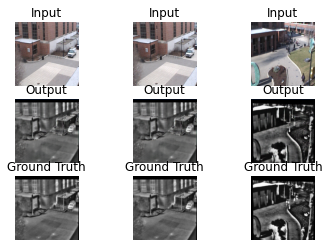

3.749788761138916
[Epoch 1/15]  [D loss: 3.749789] [G loss: 57.825966] time: 0:24:54.625926
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


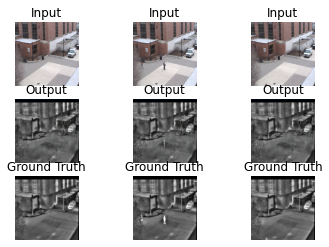

3.4558587074279785
[Epoch 2/15]  [D loss: 3.455859] [G loss: 52.571617] time: 0:36:57.970998
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


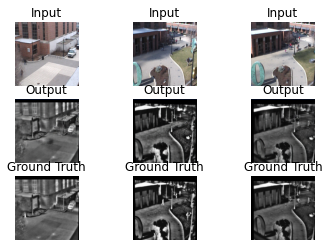

3.6233893632888794
[Epoch 3/15]  [D loss: 3.623389] [G loss: 66.355751] time: 0:49:00.899182
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


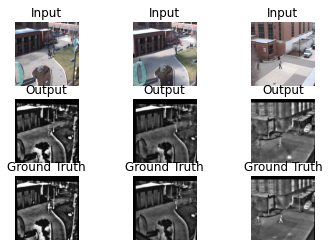

3.767574667930603
[Epoch 4/15]  [D loss: 3.767575] [G loss: 37.415108] time: 1:01:05.006632
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


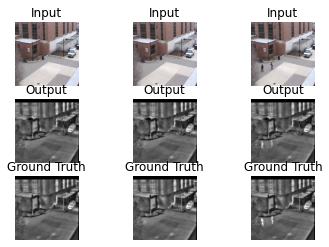

3.6462494134902954
[Epoch 5/15]  [D loss: 3.646249] [G loss: 39.168320] time: 1:13:07.199527
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


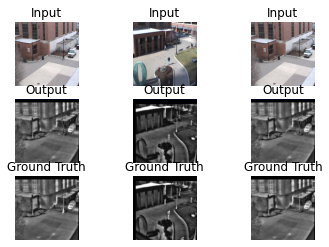

3.7413769960403442
[Epoch 6/15]  [D loss: 3.741377] [G loss: 40.335190] time: 1:25:04.846589
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


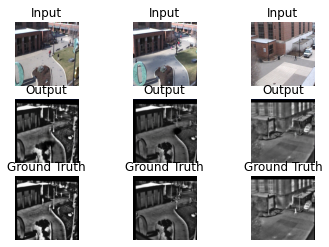

In [ ]:
train(path1,path2,1,epochs=15, batch_size=8, show_interval=1)

3.7877349853515625
[Epoch 0/10]  [D loss: 3.787735] [G loss: 51.210777] time: 0:15:46.299137
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


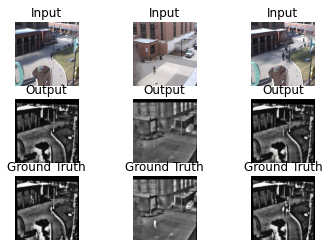

3.7978386878967285
[Epoch 1/10]  [D loss: 3.797839] [G loss: 48.957623] time: 0:30:43.103835
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


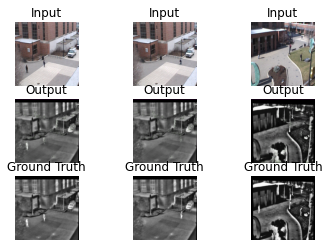

3.762998104095459
[Epoch 2/10]  [D loss: 3.762998] [G loss: 42.804379] time: 0:45:26.456832
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


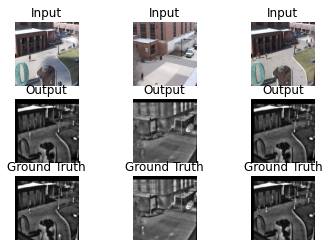

3.758566379547119
[Epoch 3/10]  [D loss: 3.758566] [G loss: 42.396637] time: 1:00:10.024193
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


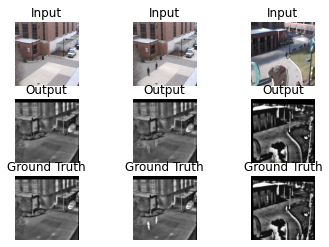

3.803859233856201
[Epoch 4/10]  [D loss: 3.803859] [G loss: 43.792843] time: 1:14:50.046801
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


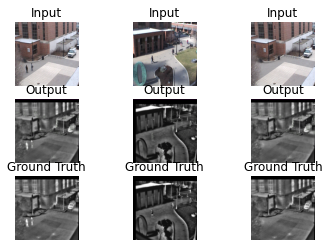

3.750342845916748
[Epoch 5/10]  [D loss: 3.750343] [G loss: 44.453922] time: 1:29:30.585551
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


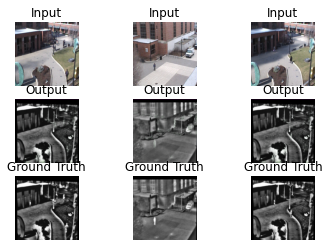

3.813201904296875
[Epoch 6/10]  [D loss: 3.813202] [G loss: 41.847271] time: 1:44:14.011810
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


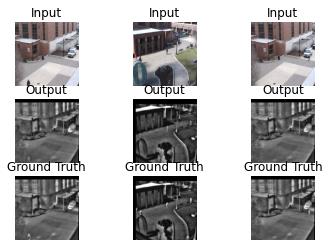

In [ ]:
train(path1,path2,1,epochs=10, batch_size=4, show_interval=1)

In [ ]:

generator.save('/content/drive/MyDrive/flir/gen1.h5')
discriminator.save('/content/drive/MyDrive/flir/disc1.h5')
combined.save('/content/drive/MyDrive/flir/combined1.h5')

In [ ]:
        epoch=[]
        for i in range(0,10):
            epoch.append(i)
        epoch_number=np.array(epoch)
        plt.plot(epoch_number.T, gloss )
        plt.plot(epoch_number.T, dloss)
        plt.grid() #creating the grid
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title("g and d losses ")
        plt.legend(["G loss","D loss"])
        plt.show()

In [ ]:
imgs_A, imgs_B = load_data(path1,path2,batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()

In [ ]:
imgs_A, imgs_B = load_data('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()

In [ ]:
def pic(d1,d2,batch_size=1, is_val=False):

        
        path2=glob('../input/images/pix/p2')
        indices=np.random.randint(0,len(path2), size=batch_size)
        #print(indices)
        #b1 = np.array(path1)[indices]
        b2 = np.array(path2)[indices]
        #print(path1)
        #print(path2)
        #plt.imshow(b1[0])
        #plt.imshow(b2[0])
        img_res=(256,256)
        
        imgs_B = []

        for i in range(0,len(b2)):
            
            i2=b2[i]
            
            img2=imread(i2)
            
            img_B = img2

            # decreasing the resolution 
            
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                
                img_B = np.fliplr(img_B)
  
                
                
            #print(img_A)
            #print(imgs_A)

            imgs_B.append(img_B)
            
            #print(imgs_A)

       
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return  imgs_B

In [ ]:
 imgs_B = pic('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[0])               
plt.show()
plt.close()
plt.imshow(gen_imgs[1])               
plt.show()
plt.close()

In [ ]:
imgs_A, imgs_B = load_data('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()